In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

### Load the Dataset

In [2]:
df = pd.read_csv(r"../data/processed/bank_churn_clean.csv")

In [3]:
df.shape

(10000, 12)

In [4]:
df.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Churn',
       'Geography_Germany', 'Geography_Spain'],
      dtype='object')

In [5]:
# selecting relevant features for clustering
# We focus on behavioral and financial features to segment customers
# based on their engagement patterns and financial profile.
# Gender and Geography are excluded to create segments based on 
# customer behavior rather than demographics.
features = [
    'CreditScore',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'IsActiveMember',
    'EstimatedSalary'
]
X = df[features]

### Scaling the data

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Applying PCA with 'n_components = 4' 

In [7]:
pca = PCA(n_components=6, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

In [8]:
print(df_pca)
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}")

           PC1       PC2       PC3       PC4       PC5       PC6
0     0.111912  1.108752 -0.632673  0.102764 -0.729480  0.381010
1    -0.835244  0.995561 -0.637200  0.167005 -1.144663  0.503680
2     0.837539 -1.040155 -0.642595  1.417501  0.795507 -0.525557
3     1.338648 -0.111938 -0.359804 -0.743908 -1.184929 -1.191319
4    -1.271847  1.476605  1.140186 -1.551136 -0.698847 -0.061165
...        ...       ...       ...       ...       ...       ...
9995  1.436381 -0.360307  0.729574 -0.805091 -0.088147 -1.129385
9996 -0.285590 -0.275397 -0.354952  1.177109  1.498626  1.536171
9997  0.302503  0.612875  0.180675 -0.914683  1.025837  0.811124
9998  0.514311 -0.078223  0.541655 -0.940668 -0.589951 -1.351436
9999 -1.109099 -0.984437  0.405929 -2.161092 -0.121144 -0.301392

[10000 rows x 6 columns]
Explained variance ratio: 0.90


# KMeans Clustering

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(X_scaled)

In [10]:
df['Cluster'] = df_pca['Cluster']

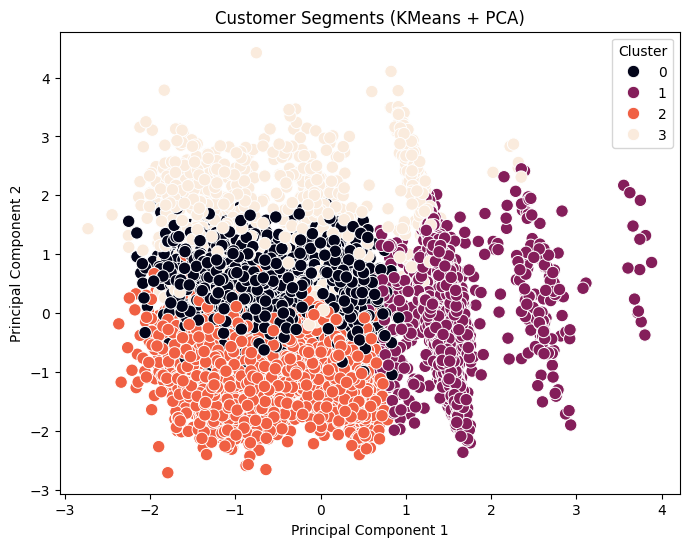

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='rocket', s=80)
plt.title('Customer Segments (KMeans + PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Cluster Profile and Summary

In [12]:
cluster_profile = df.groupby('Cluster')[features + ['Churn']].mean().round(2)
print("\n Cluster Profiles:")
print(cluster_profile)


 Cluster Profiles:
         CreditScore    Age  Tenure    Balance  NumOfProducts  IsActiveMember  \
Cluster                                                                         
0             653.23  35.30    4.84  107773.22           1.29            1.00   
1             650.46  35.92    5.14    9540.17           2.13            0.49   
2             647.28  37.47    5.08  105903.15           1.27            0.00   
3             653.22  59.88    4.94   75891.74           1.43            0.83   

         EstimatedSalary  Churn  
Cluster                          
0              100774.29   0.13  
1               99575.45   0.12  
2              101699.25   0.29  
3               94919.59   0.36  


In [13]:
df.groupby("Cluster").mean()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn,Geography_Germany,Geography_Spain
Cluster,,,,,,,,,,,,
0,653.227399,0.563630,35.303894,4.837622,107773.217841,1.293811,0.697844,1.000000,100774.288029,0.130389,0.336231,0.224270
1,650.455632,0.539297,35.922492,5.141615,9540.168711,2.127490,0.712785,0.488953,99575.454947,0.119160,0.050344,0.314741
2,647.277179,0.539575,37.473668,5.082230,105903.150246,1.266400,0.709578,0.000000,101699.246785,0.285802,0.342778,0.208808
3,653.215950,0.533154,59.879032,4.943548,75891.741676,1.429211,0.695341,0.828853,94919.588728,0.362903,0.259857,0.255376


# Cluster Analysis & Practical Interpretation

## Cluster 0 - High Balance & Very Active (Low Churn: 13%)
These clients maintain substantial balances and actively use their accounts on a regular basis. They are faithful and secure in the long run. The financial institution should persist in providing premium or personalized services to these customers in order to keep them constantly coming back.

## Cluster 1 - Many Products, Low Balance (Low Churn: 12%)
This group consumes a larger variety of products compared to others, however, their account balances are not that high. They look content with their situation in general. The bank could motivate them to develop their savings or investments.

## Cluster 2 - High Balance but Inactive (Medium Churn: 29%)
Their bank balance may be high, but on the contrary, they hardly use or communicate with the bank. The inactivity might be the reason for the higher churn in this case. These customers will require either re-engagement campaigns or targeted personal outreach.

## Cluster 3 - Older Customers with Medium Balances (High Churn: 36%)
The oldest group is also the one that is most likely to exit. They might be changing their banks because of retirement-related matters or more advantageous benefits. Marketing of retirement products or loyalty offers might be effective in preventing their exit.

Cluster
0    0.130389
1    0.119160
2    0.285802
3    0.362903
Name: Churn, dtype: float64


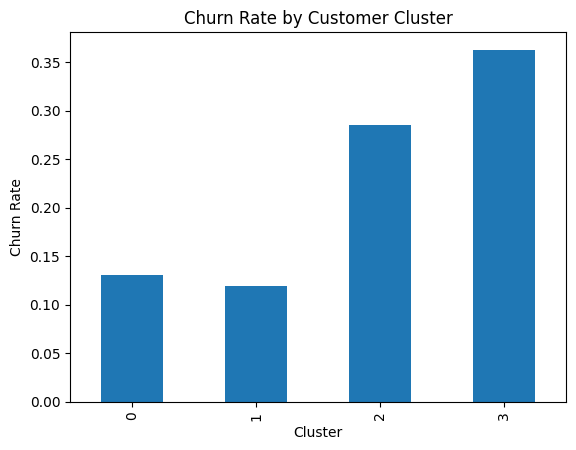

In [14]:
df['Cluster'] = kmeans.labels_
churn_by_cluster = df.groupby('Cluster')['Churn'].mean()
print(churn_by_cluster)
churn_by_cluster.plot(kind='bar')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Customer Cluster')
plt.show()

# Justification for the Optimal K Value

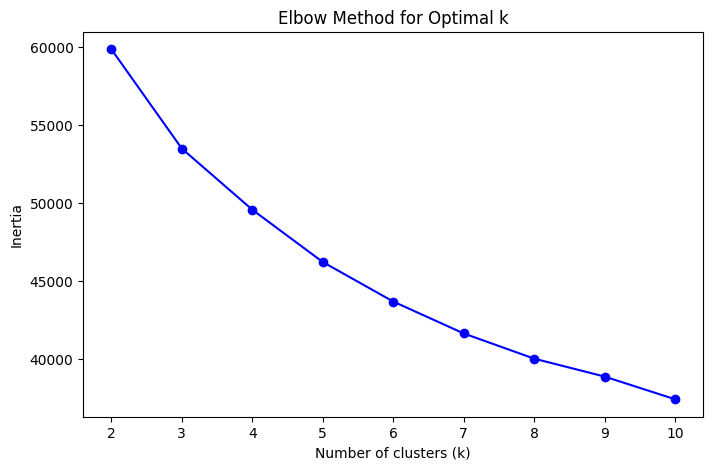

In [15]:
# elbow method to determine optimal k
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [16]:
df.to_csv("../data/processed/bank_churn_clustered.csv", index=False)

### Number of Customers Per Cluster

In [17]:
print("\n Cluster Counts:")
print(df['Cluster'].value_counts())


 Cluster Counts:
Cluster
2    3247
0    2876
1    2761
3    1116
Name: count, dtype: int64
